In [1]:
path = r'C:\Users\huda\Downloads\results_cp_all.txt'

In [2]:
with open(path, 'r') as f:
    lines = f.readlines()

In [3]:
results = dict()
for line in lines:
    data = line.split(';')
    instance = data[0]
    status = data[1]
    fitness = float(data[2])
    runtime = float(data[3])
    # ignore actual schedules for now
    results[instance] = {'status': status, 'fitness': fitness, 'runtime': runtime}

In [4]:
import pandas as pd

df = pd.DataFrame.from_dict(results).T

In [5]:
df.head()

,status,fitness,runtime
Behnke1,OPTIMAL,90.0,2.158898
Behnke10,FEASIBLE,130.0,3600.10124
Behnke11,FEASIBLE,248.0,3600.125536
Behnke12,FEASIBLE,246.0,3600.139075
Behnke13,FEASIBLE,245.0,3600.129292


In [6]:
def to_instance(source, instance):
    result = ''
    if source.startswith('0'):
        result += 'Behnke'
    elif source.startswith('1'):
        result += 'Brandimarte'
    elif source.startswith('2a'):
        result += 'HurinkSdata'
    elif source.startswith('2b'):
        result += 'HurinkEdata'
    elif source.startswith('2c'):
        result += 'HurinkRdata'
    elif source.startswith('2d'):
        result += 'HurinkVdata'
    elif source.startswith('3'):
        result += 'DPpaulli'
    elif source.startswith('4'):
        result += 'ChambersBarnes'
    elif source.startswith('5'):
        result += 'Kacem'
    else:
        result += 'Fattahi'
    return result + str(instance)

In [7]:
path_30_min = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\gurobi_results\formatted_results\30_min.txt'
path_60_min = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\gurobi_results\formatted_results\60_min.txt'
gurobi_results = dict()
with open(path_30_min, 'r') as f:
    lines = f.readlines()
    for line in lines[1:]:
        data = line.split(';')
        instance = to_instance(data[0], data[1])
        fitness = float(data[2])
        status = 'OPTIMAL' if data[4] == '2' else 'FEASIBLE'
        runtime = float(data[7])
        gurobi_results[instance] = {'status': status, 'fitness': fitness, 'runtime': runtime}
with open(path_60_min, 'r') as f:
    lines = f.readlines()
    for line in lines[1:]:
        data = line.split(';')
        instance = to_instance(data[0], data[1])
        fitness = float(data[2])
        status = 'OPTIMAL' if data[4] == '2' else 'FEASIBLE'
        runtime = float(data[7])
        gurobi_results[instance] = {'status': status, 'fitness': fitness, 'runtime': runtime}


In [8]:
df_gurobi = pd.DataFrame.from_dict(gurobi_results).T

In [9]:
df_gurobi.head()

,status,fitness,runtime
Behnke1,OPTIMAL,90.0,309.990282
Behnke2,OPTIMAL,91.0,220.229788
Behnke3,OPTIMAL,91.0,299.008287
Behnke4,FEASIBLE,96.999999,3605.001373
Behnke5,FEASIBLE,90.999999,3600.346216


In [10]:
df = pd.concat([df.assign(dataset='cp'), df_gurobi.assign(dataset='gurobi')])

In [11]:
import seaborn as sns

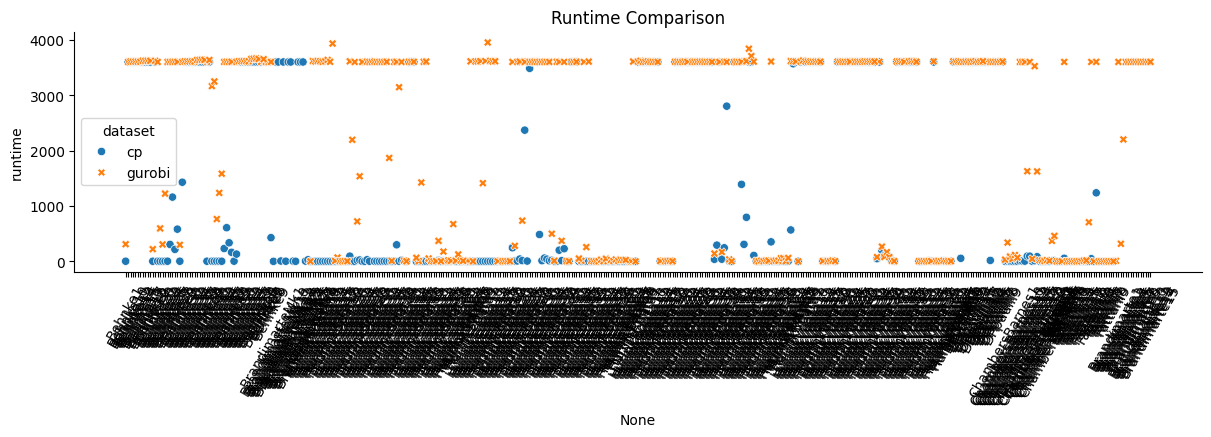

In [12]:
fg = sns.FacetGrid(data=df, aspect=4)
sns.scatterplot(x=df.index, y='runtime', data=df, hue='dataset', style='dataset').set(title='Runtime Comparison')
fg.set_xticklabels(rotation=60)

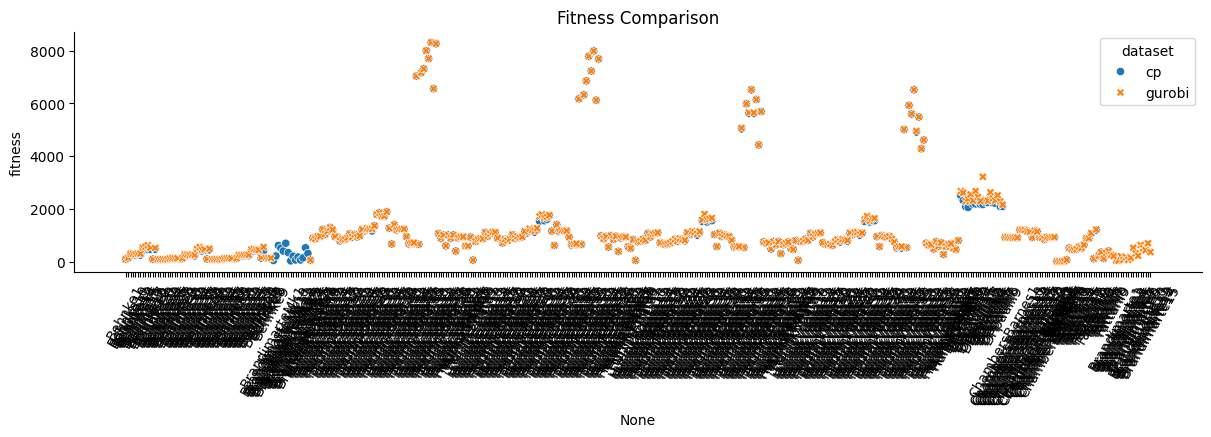

In [13]:
fg = sns.FacetGrid(data=df, aspect=4)
sns.scatterplot(x=df.index, y='fitness', data=df, hue='dataset', style='dataset').set(title='Fitness Comparison')
fg.set_xticklabels(rotation=60)

In [14]:
benchmark_base_path = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\upgrades\code\benchmarks'
def load_benchmark_info(instance):
    file = benchmark_base_path
    if instance.startswith('Behnke'):
        file += '/0_BehnkeGeiger/'
    elif instance.startswith('Brandimarte'):
        file += '/1_Brandimarte/'
    elif instance.startswith('HurinkSdata'):
        file += '/2a_Hurink_sdata/'
    elif instance.startswith('HurinkEdata'):
        file += '/2b_Hurink_edata/'
    elif instance.startswith('HurinkRdata'):
        file += '/2c_Hurink_rdata/'
    elif instance.startswith('HurinkVdata'):
        file += '/2d_Hurink_vdata/'
    elif instance.startswith('DPpaulli'):
        file += '/3_DPpaulli/'
    elif instance.startswith('Chambers'):
        file += '/4_ChambersBarnes/'
    elif instance.startswith('Kacem'):
        file += '/5_Kacem/'
    else:
        file += '/6_Fattahi/'
    file += instance + '.fjs'
    with open(file, 'r') as f:
        lines = f.readlines()
    benchmark_system = lines[0].split(' ')
    n_machines = int(benchmark_system[0])
    n_jobs = int(benchmark_system[1])
    average_machines = float(benchmark_system[2])
    jobs = lines[1:]
    n_operations = sum([int(x.split(' ')[0]) for x in jobs])
    average_operations = n_operations / n_jobs
    flexibility = average_machines / n_machines
    return n_machines, n_jobs, n_operations, average_machines, average_operations, flexibility

In [15]:
joined = []
for entry in results.keys():
    if entry in gurobi_results:
        n_machines, n_jobs, n_operations, average_machines, average_operations, flexibility = load_benchmark_info(entry)
        gurobi_entry = {
            'instance': entry, 
            'status': gurobi_results[entry]['status'], 
            'fitness': gurobi_results[entry]['fitness'], 
            'runtime': gurobi_results[entry]['runtime'], 
            'dataset': 'gurobi',
            'n_machines': n_machines,
            'n_jobs': n_jobs,
            'n_operations': n_operations,
            'average_machines': average_machines,
            'average_operations': average_operations,
            'flexibility': flexibility
            }
        cp_entry = {
            'instance': entry, 
            'status': results[entry]['status'], 
            'fitness': results[entry]['fitness'], 
            'runtime': results[entry]['runtime'], 
            'dataset': 'cp',
            'n_machines': n_machines,
            'n_jobs': n_jobs,
            'n_operations': n_operations,
            'average_machines': average_machines,
            'average_operations': average_operations,
            'flexibility': flexibility
            }
        joined.append(cp_entry)
        joined.append(gurobi_entry)

In [16]:
df_joined = pd.DataFrame(joined)

In [17]:
df_joined.head()

,instance,status,fitness,runtime,dataset,n_machines,n_jobs,n_operations,average_machines,average_operations,flexibility
0,Behnke1,OPTIMAL,90.0,2.158898,cp,10,20,50,6.08,2.5,0.6080
1,Behnke1,OPTIMAL,90.0,309.990282,gurobi,10,20,50,6.08,2.5,0.6080
2,Behnke10,FEASIBLE,130.0,3600.101240,cp,20,20,100,6.12,5.0,0.3060
3,Behnke10,FEASIBLE,140.0,3601.383659,gurobi,20,20,100,6.12,5.0,0.3060
4,Behnke11,FEASIBLE,248.0,3600.125536,cp,50,20,250,6.42,12.5,0.1284


In [18]:
df = df_joined

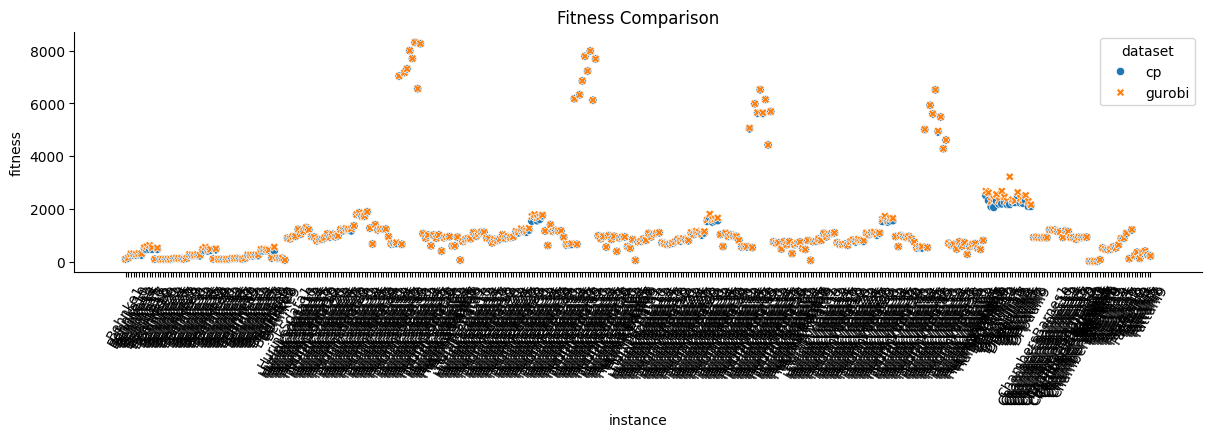

In [19]:
fg = sns.FacetGrid(data=df, aspect=4)
sns.scatterplot(x='instance', y='fitness', data=df, hue='dataset', style='dataset').set(title='Fitness Comparison')
fg.set_xticklabels(rotation=60)

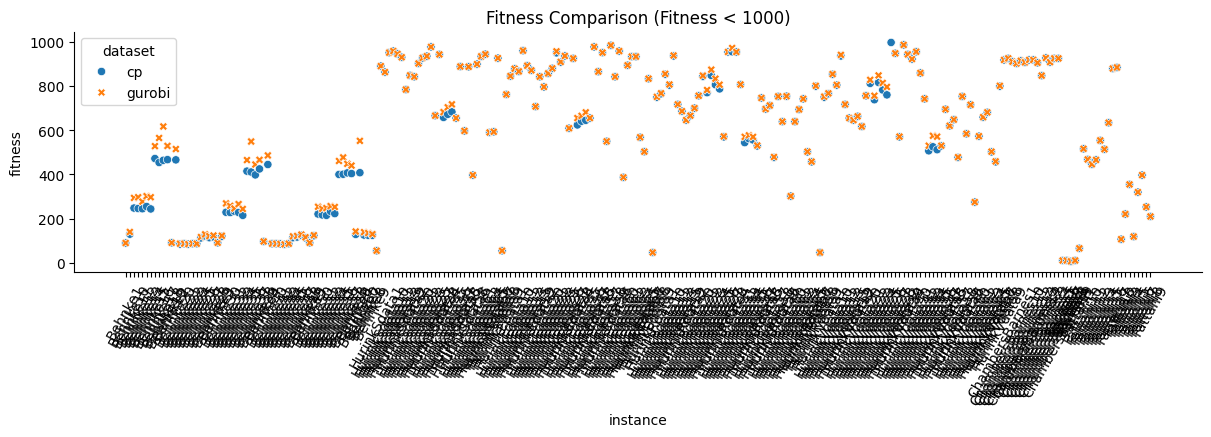

In [20]:
fg = sns.FacetGrid(data=df, aspect=4)
sns.scatterplot(x='instance', y='fitness', data=df.loc[df['fitness'] < 1000], hue='dataset', style='dataset').set(title='Fitness Comparison (Fitness < 1000)')
fg.set_xticklabels(rotation=60)

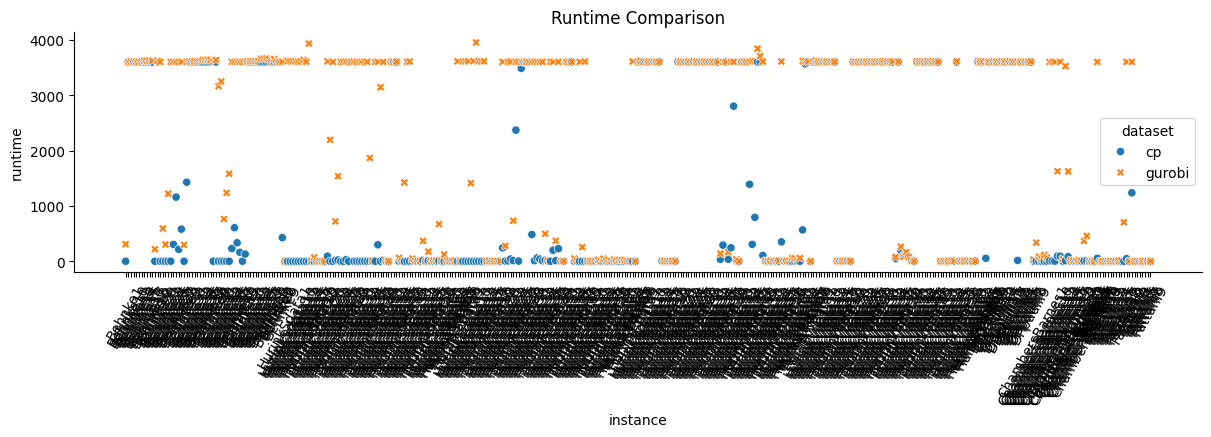

In [21]:
fg = sns.FacetGrid(data=df, aspect=4)
sns.scatterplot(x='instance', y='runtime', data=df, hue='dataset', style='dataset').set(title='Runtime Comparison')
fg.set_xticklabels(rotation=60)

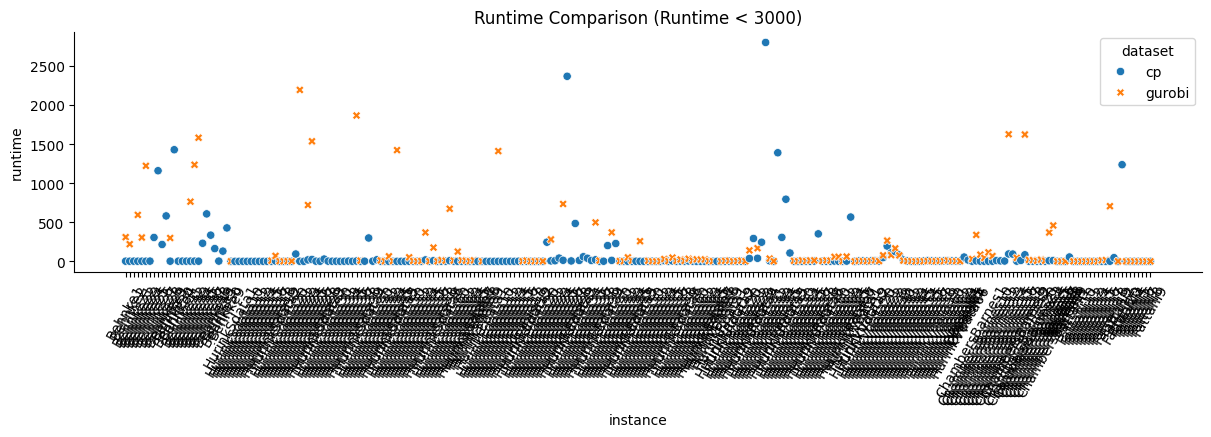

In [22]:
fg = sns.FacetGrid(data=df, aspect=4)
sns.scatterplot(x='instance', y='runtime', data=df.loc[df['runtime'] < 3000], hue='dataset', style='dataset').set(title='Runtime Comparison (Runtime < 3000)')
fg.set_xticklabels(rotation=60)

[Text(0.5, 1.0, 'Log Fitness Comparison')]

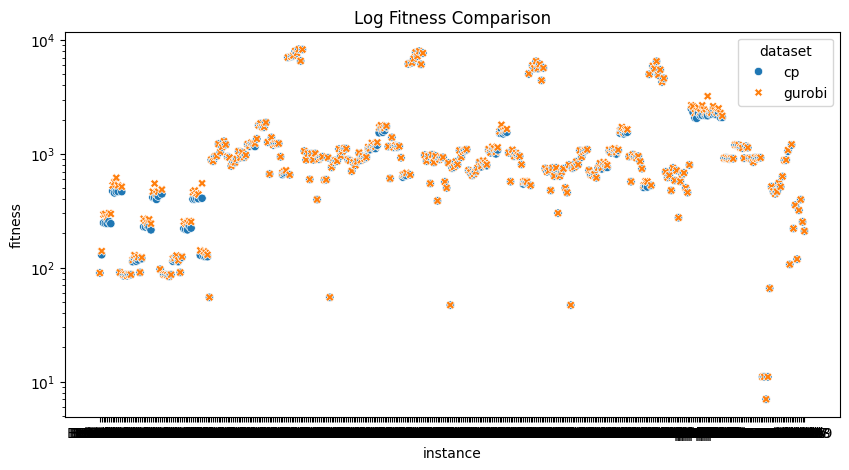

In [23]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
ax.set(yscale="log")
sns.scatterplot(x='instance', y='fitness', ax=ax, data=df, hue='dataset', style='dataset').set(title='Log Fitness Comparison')

[Text(0.5, 1.0, 'Log Runtime Comparison')]

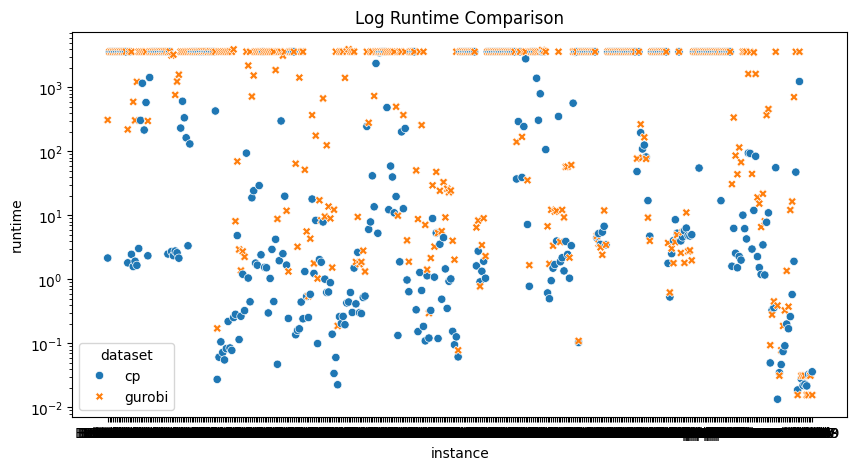

In [24]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
ax.set(yscale="log")
sns.scatterplot(x='instance', y='runtime', ax=ax, data=df, hue='dataset', style='dataset').set(title='Log Runtime Comparison')

<Axes: xlabel='status', ylabel='Count'>

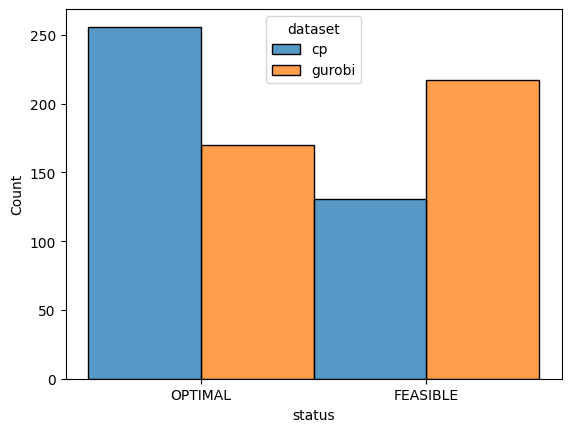

In [25]:
sns.histplot(data=df, x='status', hue='dataset', multiple='dodge')

In [26]:
df.loc[df['instance'] == 'Behnke60']

,instance,status,fitness,runtime,dataset,n_machines,n_jobs,n_operations,average_machines,average_operations,flexibility
112,Behnke60,FEASIBLE,408.0,3600.541954,cp,100,60,500,17.65,8.333333,0.1765
113,Behnke60,FEASIBLE,552.0,3650.703823,gurobi,100,60,500,17.65,8.333333,0.1765


[Text(0.5, 1.0, 'Log Fitness and Log Runtime')]

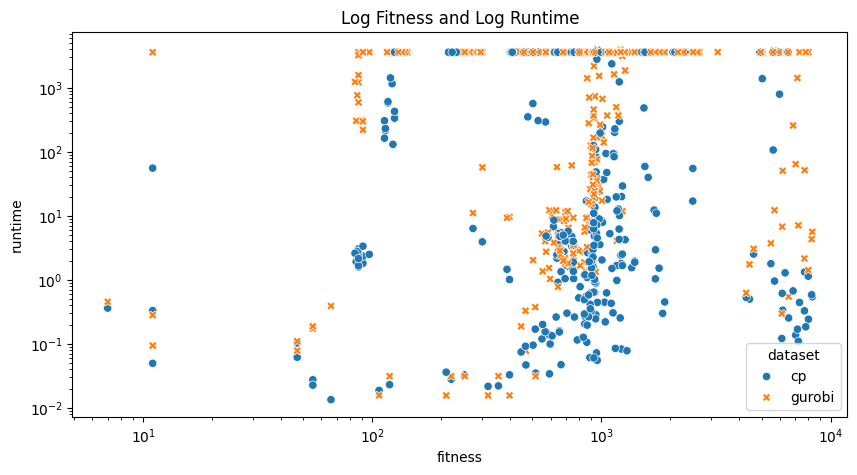

In [27]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x='fitness', y='runtime', ax=ax, data=df, hue='dataset', style='dataset').set(title='Log Fitness and Log Runtime')

[Text(0.5, 1.0, '# Operations and Log Runtime')]

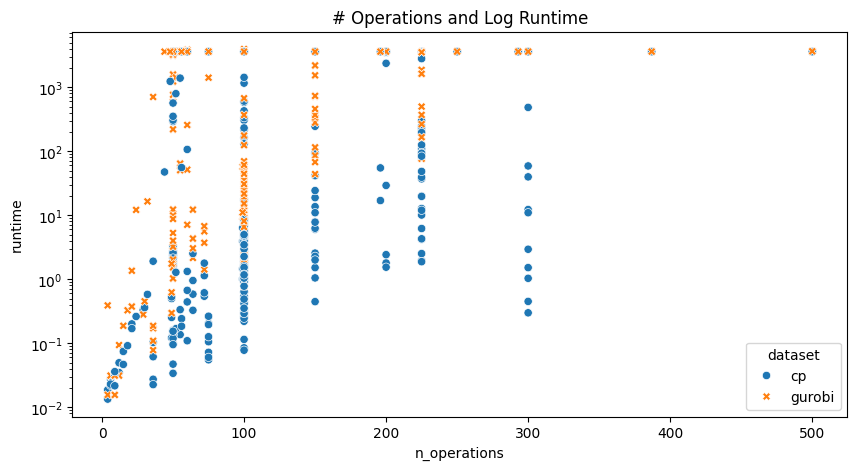

In [28]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
ax.set(yscale="log")
sns.scatterplot(x='n_operations', y='runtime', ax=ax, data=df, hue='dataset', style='dataset').set(title='# Operations and Log Runtime')

[Text(0.5, 1.0, '# Machines and Log Runtime')]

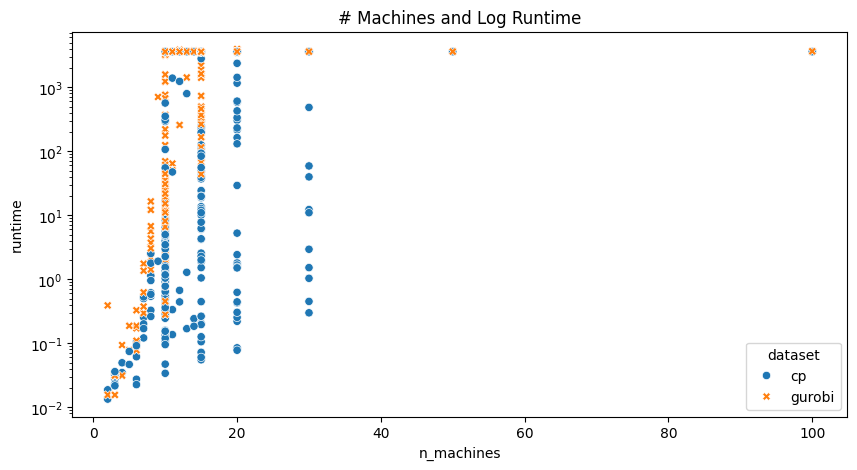

In [29]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
ax.set(yscale="log")
sns.scatterplot(x='n_machines', y='runtime', ax=ax, data=df, hue='dataset', style='dataset').set(title='# Machines and Log Runtime')

[Text(0.5, 1.0, 'Average Machines (per Operation) and Log Runtime')]

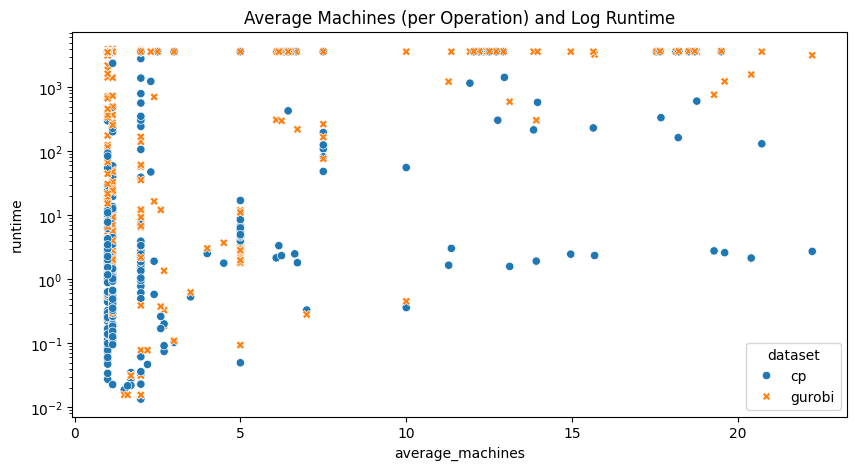

In [30]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
ax.set(yscale="log")
sns.scatterplot(x='average_machines', y='runtime', ax=ax, data=df, hue='dataset', style='dataset').set(title='Average Machines (per Operation) and Log Runtime')

[Text(0.5, 1.0, 'Average Machines (per Operation) and Log Fitness')]

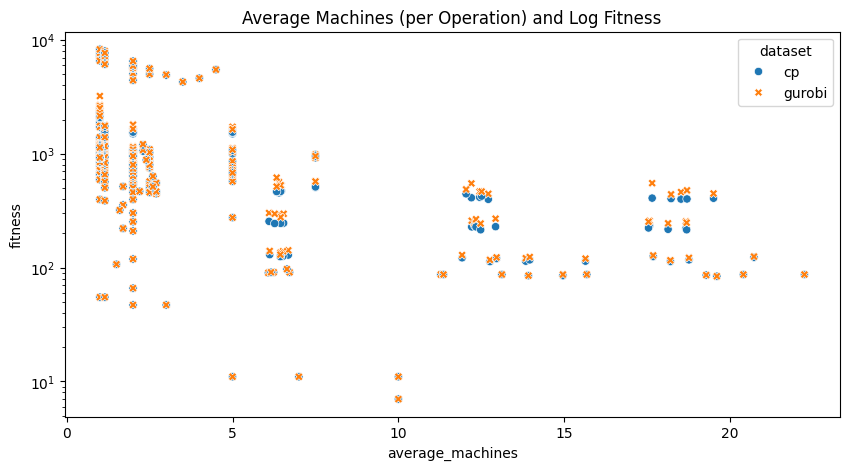

In [31]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
ax.set(yscale="log")
sns.scatterplot(x='average_machines', y='fitness', ax=ax, data=df, hue='dataset', style='dataset').set(title='Average Machines (per Operation) and Log Fitness')

[Text(0.5, 1.0, 'Average Operations (per Job) and Log Runtime')]

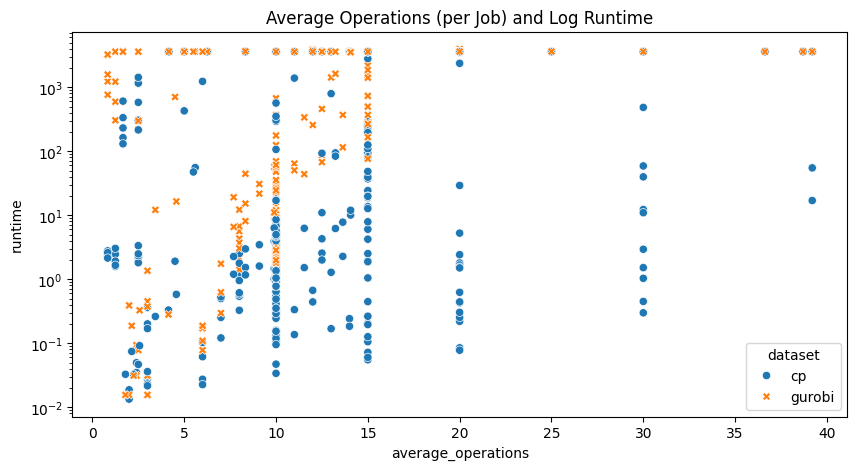

In [41]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
ax.set(yscale="log")
sns.scatterplot(x='average_operations', y='runtime', ax=ax, data=df, hue='dataset', style='dataset').set(title='Average Operations (per Job) and Log Runtime')

[Text(0.5, 1.0, 'Average Operations (per Job) and Log Fitness')]

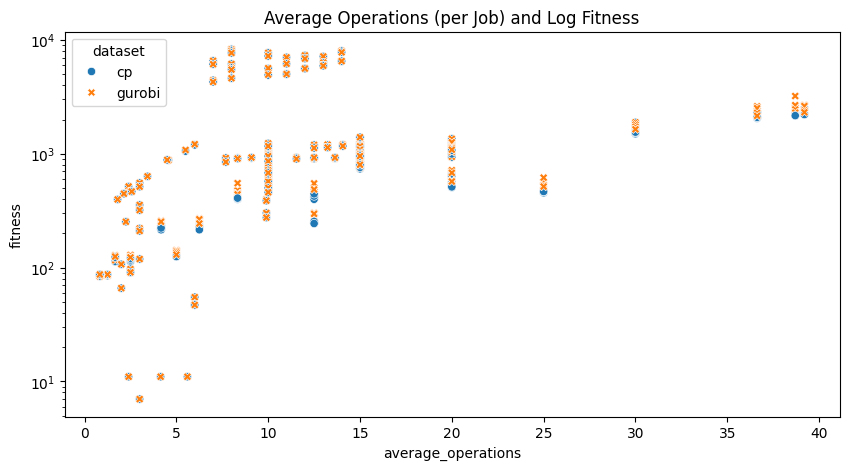

In [33]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
ax.set(yscale="log")
sns.scatterplot(x='average_operations', y='fitness', ax=ax, data=df, hue='dataset', style='dataset').set(title='Average Operations (per Job) and Log Fitness')

[Text(0.5, 1.0, 'Log Runtime Comparison')]

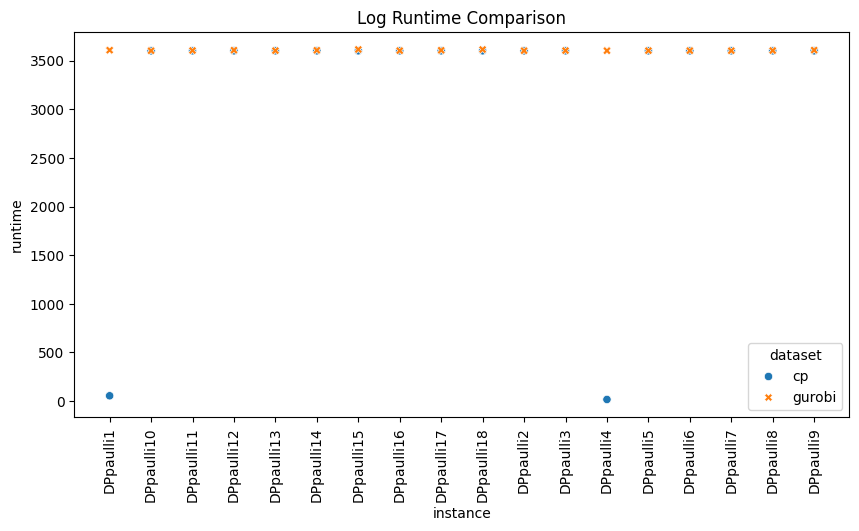

In [44]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
#ax.set(yscale="log")
plt.xticks(rotation=90)
sns.scatterplot(x='instance', y='runtime', ax=ax, data=df.loc[df['instance'].str.contains('DPpaulli')], hue='dataset', style='dataset').set(title='Log Runtime Comparison')

[Text(0.5, 1.0, 'Log Runtime Comparison')]

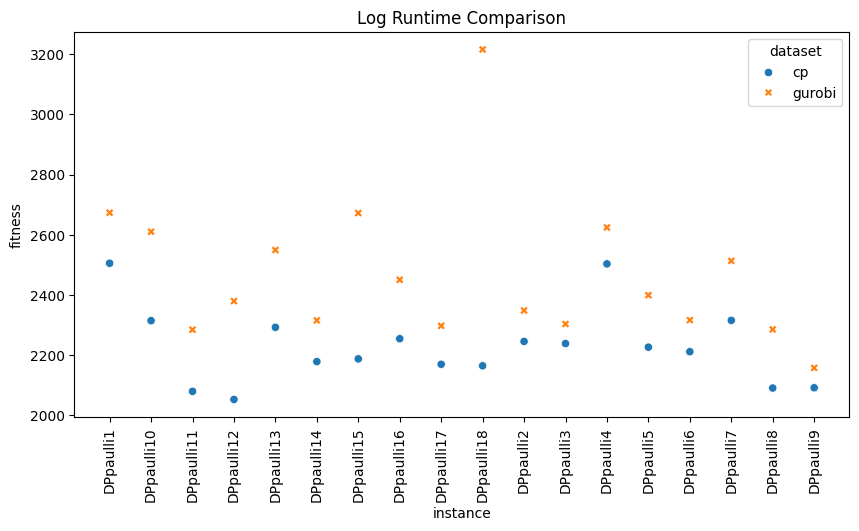

In [43]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
#ax.set(yscale="log")
plt.xticks(rotation=90)
sns.scatterplot(x='instance', y='fitness', ax=ax, data=df.loc[df['instance'].str.contains('DPpaulli')], hue='dataset', style='dataset').set(title='Log Runtime Comparison')